In [1]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Using TensorFlow backend.


In [2]:
# Import input (x) and output (y) data, and asign these to df1 and df1

df1 = pd.read_csv('StatsVideosXALL.csv')
df2 = pd.read_csv('StatsVideosYALL.csv')

In [3]:
result = pd.concat([df1,df2],axis=1,sort=False)

In [4]:
#find the share of the result object
result.shape

(3364, 4)

In [5]:
df1=result[['Dislikes','Likes','Subscribers']]
df2=result['Views']

In [6]:
result.head()

,Likes,Dislikes,Subscribers,Views
0,104460,3365,7300000,1988888
1,103203,3570,3300000,2617005
2,22485,612,1800000,932230
3,23077,1337,465000,1165800
4,12315,522,11000000,551165


In [7]:
# Split the data into input (x) training and testing data, and ouput (y) training and testing data, 
# with training data being 80% of the data, and testing data being the remaining 20% of the data

X_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.2, random_state = 0)

In [8]:
X_test.head()

,Dislikes,Likes,Subscribers
2824,1653,11232,165000
1813,682,52234,1900000
706,68,749,56000
1680,5974,105291,10000000
1694,498,11280,3700000


In [9]:
# Scale both training and testing input data
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)
y_train = preprocessing.scale(y_train)
y_test = preprocessing.scale(y_test)

# Example with 500 epochs

In [10]:
# Defines "deep" model and its structure using Adam optimizer and mean_squared_error
model = Sequential()
model.add(Dense(13, input_shape=(3,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1,))
model.compile(optimizer='adam', loss='mean_squared_error')

# Runs model for 500 iterations and assigns this to 'history'
history = model.fit(X_train, y_train, epochs = 500, validation_split = 0.2, verbose = 0)

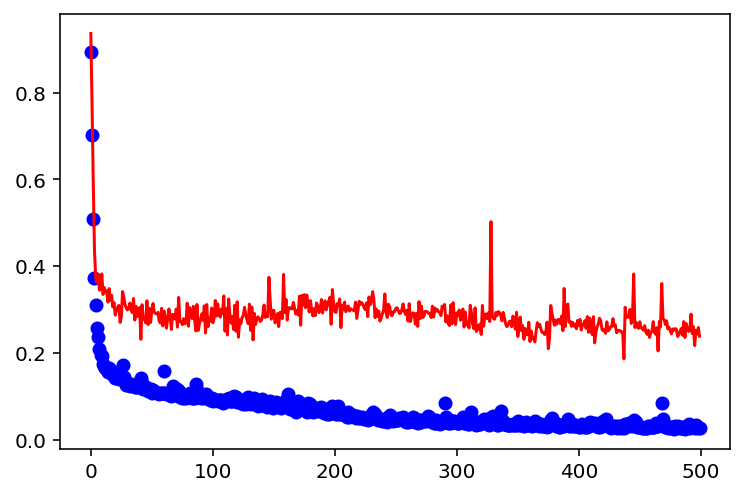

In [11]:
# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

# Example with early stopping function

In [12]:

# Pass several parameters to 'EarlyStopping' function and assigns it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fits model over 2000 iterations with 'earlystopper' callback, and assigns it to history
history = model.fit(X_train, y_train, epochs = 2000, validation_split = 0.2,shuffle = True, verbose = 0, 
                    callbacks = [earlystopper])

Epoch 00021: early stopping


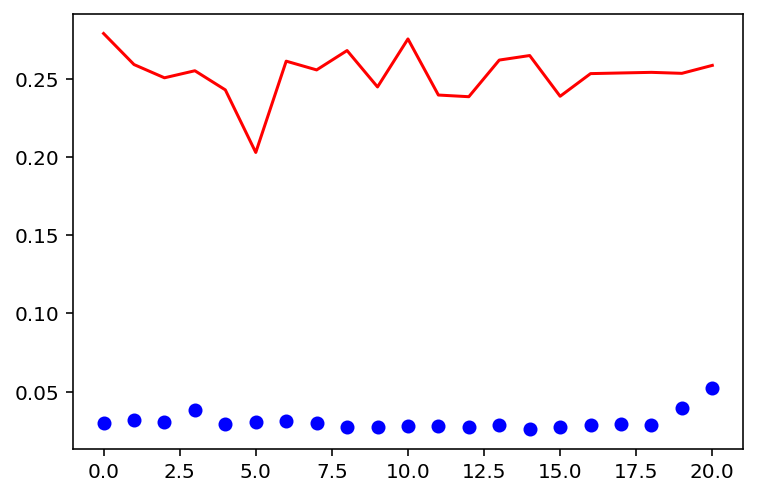

In [13]:
# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

In [14]:
# Runs model with its current weights on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.925
The R2 score on the Test set is:	0.840


# HYPERPARAMETER TUNING - OPTIMIZER

In [15]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(13, input_shape=(3,), activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1,))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return model

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train,y_train)

C:\Users\aravi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [16]:
grid.best_params_

{'optimizer': 'Adagrad'}

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

# Runs model with its current weights on the training and testing data
y_train_pred_1 = grid_result.predict(X_train)
y_test_pred_1 = grid_result.predict(X_test)

    
# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_1)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred_1)))

Best: -0.807841 using {'optimizer': 'Adagrad'}
-3.469549 (4.368497) with: {'optimizer': 'SGD'}
-1.585559 (1.870599) with: {'optimizer': 'RMSprop'}
-0.807841 (0.768495) with: {'optimizer': 'Adagrad'}
-1.044635 (1.068158) with: {'optimizer': 'Adadelta'}
-2.058677 (2.604556) with: {'optimizer': 'Adam'}
-1.310262 (1.484081) with: {'optimizer': 'Adamax'}
-1.325967 (1.530479) with: {'optimizer': 'Nadam'}
The R2 score on the Train set is:	0.886
The R2 score on the Test set is:	0.879
